# Introductory CNN Model: MNIST Digits

----------------------------------

In this example, we will download the MNIST handwritten digits and create a simple CNN network to predict the digit category (0-9).

To start, we load the necessary libraries.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
from tensorflow.python.framework import ops
ops.reset_default_graph()


Start a computational graph session:

In [2]:
# Start a graph session
sess = tf.Session()


TensorFlow has a built in method for loading the MNIST data sets.  It checks to see if you have downloaded it before, and if not, downloads and saves the files for you.

In [3]:
# Load data
data_dir = 'temp'
mnist = read_data_sets(data_dir)

Extracting temp/train-images-idx3-ubyte.gz


Extracting temp/train-labels-idx1-ubyte.gz
Extracting temp/t10k-images-idx3-ubyte.gz
Extracting temp/t10k-labels-idx1-ubyte.gz


Now we convert the images to have a size of 28x28.  They are downloaded as a 1x784 array.

In [5]:
# Convert images into 28x28 (they are downloaded as 1x784)
train_xdata = np.array([np.reshape(x, (28,28)) for x in mnist.train.images])
test_xdata = np.array([np.reshape(x, (28,28)) for x in mnist.test.images])

# Convert labels into one-hot encoded vectors
train_labels = mnist.train.labels
test_labels = mnist.test.labels

Now we set the model parameters as follows.

In [6]:
# Set model parameters
batch_size = 100
learning_rate = 0.005
evaluation_size = 500
image_width = train_xdata[0].shape[0]
image_height = train_xdata[0].shape[1]
target_size = max(train_labels) + 1
num_channels = 1 # greyscale = 1 channel
generations = 500
eval_every = 5
conv1_features = 25
conv2_features = 50
max_pool_size1 = 2 # NxN window for 1st max pool layer
max_pool_size2 = 2 # NxN window for 2nd max pool layer
fully_connected_size1 = 100

Declare model placeholders.  Remember that we need placeholders for the training data and the evaluation data.

In [7]:
x_input_shape = (batch_size, image_width, image_height, num_channels)
x_input = tf.placeholder(tf.float32, shape=x_input_shape)
y_target = tf.placeholder(tf.int32, shape=(batch_size))

eval_input_shape = (evaluation_size, image_width, image_height, num_channels)
eval_input = tf.placeholder(tf.float32, shape=eval_input_shape)
eval_target = tf.placeholder(tf.int32, shape=(evaluation_size))

Here we declare model parameters.  For this model we will have two convolutional layers (each having filter size 4x4).  We follow this with two fully connected layers.

In [8]:
# Convolutional layer variables
conv1_weight = tf.Variable(tf.truncated_normal([4, 4, num_channels, conv1_features],
                                               stddev=0.1, dtype=tf.float32))
conv1_bias = tf.Variable(tf.zeros([conv1_features], dtype=tf.float32))

conv2_weight = tf.Variable(tf.truncated_normal([4, 4, conv1_features, conv2_features],
                                               stddev=0.1, dtype=tf.float32))
conv2_bias = tf.Variable(tf.zeros([conv2_features], dtype=tf.float32))

# fully connected variables
resulting_width = image_width // (max_pool_size1 * max_pool_size2)
resulting_height = image_height // (max_pool_size1 * max_pool_size2)
full1_input_size = resulting_width * resulting_height * conv2_features
full1_weight = tf.Variable(tf.truncated_normal([full1_input_size, fully_connected_size1],
                          stddev=0.1, dtype=tf.float32))
full1_bias = tf.Variable(tf.truncated_normal([fully_connected_size1], stddev=0.1, dtype=tf.float32))
full2_weight = tf.Variable(tf.truncated_normal([fully_connected_size1, target_size],
                                               stddev=0.1, dtype=tf.float32))
full2_bias = tf.Variable(tf.truncated_normal([target_size], stddev=0.1, dtype=tf.float32))

After we have the layer variables, we can create the model operations.

   (Convolutional layer 1) --> (ReLU 1) --> (Max Pool 1) -->


-->(Convolutional layer 2) --> (ReLU 2) --> (Max Pool 2) -->


-->(Fully Connected Layer 1) --> (Fully Connected Layer 2) --> Prediction.

In [9]:
# Initialize Model Operations
def my_conv_net(input_data):
    # First Conv-ReLU-MaxPool Layer
    conv1 = tf.nn.conv2d(input_data, conv1_weight, strides=[1, 1, 1, 1], padding='SAME')
    relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_bias))
    max_pool1 = tf.nn.max_pool(relu1, ksize=[1, max_pool_size1, max_pool_size1, 1],
                               strides=[1, max_pool_size1, max_pool_size1, 1], padding='SAME')

    # Second Conv-ReLU-MaxPool Layer
    conv2 = tf.nn.conv2d(max_pool1, conv2_weight, strides=[1, 1, 1, 1], padding='SAME')
    relu2 = tf.nn.relu(tf.nn.bias_add(conv2, conv2_bias))
    max_pool2 = tf.nn.max_pool(relu2, ksize=[1, max_pool_size2, max_pool_size2, 1],
                               strides=[1, max_pool_size2, max_pool_size2, 1], padding='SAME')

    # Transform Output into a 1xN layer for next fully connected layer
    final_conv_shape = max_pool2.get_shape().as_list()
    final_shape = final_conv_shape[1] * final_conv_shape[2] * final_conv_shape[3]
    flat_output = tf.reshape(max_pool2, [final_conv_shape[0], final_shape])

    # First Fully Connected Layer
    fully_connected1 = tf.nn.relu(tf.add(tf.matmul(flat_output, full1_weight), full1_bias))

    # Second Fully Connected Layer
    final_model_output = tf.add(tf.matmul(fully_connected1, full2_weight), full2_bias)
    
    return(final_model_output)

model_output = my_conv_net(x_input)
test_model_output = my_conv_net(eval_input)

We will us the softmax cross entropy loss.

In [10]:
# Declare Loss Function (softmax cross entropy)
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model_output, labels=y_target))

We also create a prediction and accuracy function for evaluation on the train and test set.

In [11]:
# Create a prediction function
prediction = tf.nn.softmax(model_output)
test_prediction = tf.nn.softmax(test_model_output)

# Create accuracy function
def get_accuracy(logits, targets):
    batch_predictions = np.argmax(logits, axis=1)
    num_correct = np.sum(np.equal(batch_predictions, targets))
    return(100. * num_correct/batch_predictions.shape[0])

Here, we will use the Momentum Optimizer with a learning rate of `0.005` and a decay rate of `0.9`.  Then we initialize our model variables.

In [12]:
# Create an optimizer
my_optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9)
train_step = my_optimizer.minimize(loss)

# Initialize Variables
init = tf.global_variables_initializer()
sess.run(init)

Now we can start training!

In [13]:
# Start training loop
train_loss = []
train_acc = []
test_acc = []
for i in range(generations):
    rand_index = np.random.choice(len(train_xdata), size=batch_size)
    rand_x = train_xdata[rand_index]
    rand_x = np.expand_dims(rand_x, 3)
    rand_y = train_labels[rand_index]
    train_dict = {x_input: rand_x, y_target: rand_y}
    
    sess.run(train_step, feed_dict=train_dict)
    temp_train_loss, temp_train_preds = sess.run([loss, prediction], feed_dict=train_dict)
    temp_train_acc = get_accuracy(temp_train_preds, rand_y)
    
    if (i+1) % eval_every == 0:
        eval_index = np.random.choice(len(test_xdata), size=evaluation_size)
        eval_x = test_xdata[eval_index]
        eval_x = np.expand_dims(eval_x, 3)
        eval_y = test_labels[eval_index]
        test_dict = {eval_input: eval_x, eval_target: eval_y}
        test_preds = sess.run(test_prediction, feed_dict=test_dict)
        temp_test_acc = get_accuracy(test_preds, eval_y)
        
        # Record and print results
        train_loss.append(temp_train_loss)
        train_acc.append(temp_train_acc)
        test_acc.append(temp_test_acc)
        acc_and_loss = [(i+1), temp_train_loss, temp_train_acc, temp_test_acc]
        acc_and_loss = [np.round(x,2) for x in acc_and_loss]
        print('Generation # {}. Train Loss: {:.2f}. Train Acc (Test Acc): {:.2f} ({:.2f})'.format(*acc_and_loss))

Generation # 5. Train Loss: 2.30. Train Acc (Test Acc): 16.00 (14.80)


Generation # 10. Train Loss: 2.19. Train Acc (Test Acc): 24.00 (28.20)


Generation # 15. Train Loss: 2.09. Train Acc (Test Acc): 45.00 (34.00)


Generation # 20. Train Loss: 2.02. Train Acc (Test Acc): 52.00 (44.00)


Generation # 25. Train Loss: 1.75. Train Acc (Test Acc): 63.00 (52.20)


Generation # 30. Train Loss: 1.62. Train Acc (Test Acc): 65.00 (61.00)


Generation # 35. Train Loss: 1.44. Train Acc (Test Acc): 69.00 (63.80)


Generation # 40. Train Loss: 1.13. Train Acc (Test Acc): 67.00 (66.60)


Generation # 45. Train Loss: 0.79. Train Acc (Test Acc): 76.00 (77.00)


Generation # 50. Train Loss: 0.74. Train Acc (Test Acc): 76.00 (79.00)


Generation # 55. Train Loss: 0.71. Train Acc (Test Acc): 79.00 (80.40)


Generation # 60. Train Loss: 0.59. Train Acc (Test Acc): 84.00 (86.60)


Generation # 65. Train Loss: 0.43. Train Acc (Test Acc): 86.00 (84.80)


Generation # 70. Train Loss: 0.41. Train Acc (Test Acc): 85.00 (83.40)


Generation # 75. Train Loss: 0.40. Train Acc (Test Acc): 86.00 (86.20)


Generation # 80. Train Loss: 0.62. Train Acc (Test Acc): 83.00 (87.40)


Generation # 85. Train Loss: 0.37. Train Acc (Test Acc): 88.00 (87.40)


Generation # 90. Train Loss: 0.27. Train Acc (Test Acc): 93.00 (86.20)


Generation # 95. Train Loss: 0.30. Train Acc (Test Acc): 93.00 (91.40)


Generation # 100. Train Loss: 0.29. Train Acc (Test Acc): 90.00 (88.40)


Generation # 105. Train Loss: 0.37. Train Acc (Test Acc): 88.00 (88.40)


Generation # 110. Train Loss: 0.44. Train Acc (Test Acc): 88.00 (91.00)


Generation # 115. Train Loss: 0.26. Train Acc (Test Acc): 94.00 (91.60)


Generation # 120. Train Loss: 0.28. Train Acc (Test Acc): 95.00 (90.80)


Generation # 125. Train Loss: 0.26. Train Acc (Test Acc): 91.00 (89.00)


Generation # 130. Train Loss: 0.22. Train Acc (Test Acc): 94.00 (91.20)


Generation # 135. Train Loss: 0.40. Train Acc (Test Acc): 86.00 (89.80)


Generation # 140. Train Loss: 0.30. Train Acc (Test Acc): 92.00 (91.00)


Generation # 145. Train Loss: 0.38. Train Acc (Test Acc): 87.00 (90.60)


Generation # 150. Train Loss: 0.34. Train Acc (Test Acc): 86.00 (90.80)


Generation # 155. Train Loss: 0.24. Train Acc (Test Acc): 91.00 (89.60)


Generation # 160. Train Loss: 0.24. Train Acc (Test Acc): 91.00 (91.40)


Generation # 165. Train Loss: 0.11. Train Acc (Test Acc): 98.00 (92.20)


Generation # 170. Train Loss: 0.13. Train Acc (Test Acc): 97.00 (91.20)


Generation # 175. Train Loss: 0.16. Train Acc (Test Acc): 94.00 (90.80)


Generation # 180. Train Loss: 0.36. Train Acc (Test Acc): 91.00 (92.00)


Generation # 185. Train Loss: 0.10. Train Acc (Test Acc): 98.00 (92.80)


Generation # 190. Train Loss: 0.35. Train Acc (Test Acc): 92.00 (91.60)


Generation # 195. Train Loss: 0.17. Train Acc (Test Acc): 95.00 (90.60)


Generation # 200. Train Loss: 0.21. Train Acc (Test Acc): 95.00 (94.20)


Generation # 205. Train Loss: 0.18. Train Acc (Test Acc): 93.00 (93.60)


Generation # 210. Train Loss: 0.25. Train Acc (Test Acc): 90.00 (94.00)


Generation # 215. Train Loss: 0.25. Train Acc (Test Acc): 91.00 (92.80)


Generation # 220. Train Loss: 0.23. Train Acc (Test Acc): 92.00 (92.60)


Generation # 225. Train Loss: 0.13. Train Acc (Test Acc): 96.00 (92.20)


Generation # 230. Train Loss: 0.21. Train Acc (Test Acc): 94.00 (93.40)


Generation # 235. Train Loss: 0.20. Train Acc (Test Acc): 95.00 (92.20)


Generation # 240. Train Loss: 0.32. Train Acc (Test Acc): 92.00 (92.60)


Generation # 245. Train Loss: 0.12. Train Acc (Test Acc): 97.00 (94.00)


Generation # 250. Train Loss: 0.15. Train Acc (Test Acc): 94.00 (94.80)


Generation # 255. Train Loss: 0.25. Train Acc (Test Acc): 90.00 (93.20)


Generation # 260. Train Loss: 0.24. Train Acc (Test Acc): 94.00 (95.40)


Generation # 265. Train Loss: 0.18. Train Acc (Test Acc): 96.00 (93.40)


Generation # 270. Train Loss: 0.30. Train Acc (Test Acc): 89.00 (93.80)


Generation # 275. Train Loss: 0.35. Train Acc (Test Acc): 88.00 (93.40)


Generation # 280. Train Loss: 0.19. Train Acc (Test Acc): 95.00 (93.80)


Generation # 285. Train Loss: 0.13. Train Acc (Test Acc): 94.00 (94.80)


Generation # 290. Train Loss: 0.13. Train Acc (Test Acc): 95.00 (94.60)


Generation # 295. Train Loss: 0.20. Train Acc (Test Acc): 92.00 (94.80)


Generation # 300. Train Loss: 0.17. Train Acc (Test Acc): 95.00 (95.40)


Generation # 305. Train Loss: 0.11. Train Acc (Test Acc): 98.00 (95.60)


Generation # 310. Train Loss: 0.16. Train Acc (Test Acc): 96.00 (94.80)


Generation # 315. Train Loss: 0.07. Train Acc (Test Acc): 99.00 (96.60)


Generation # 320. Train Loss: 0.20. Train Acc (Test Acc): 95.00 (93.00)


Generation # 325. Train Loss: 0.16. Train Acc (Test Acc): 95.00 (95.40)


Generation # 330. Train Loss: 0.22. Train Acc (Test Acc): 93.00 (95.20)


Generation # 335. Train Loss: 0.22. Train Acc (Test Acc): 92.00 (93.80)


Generation # 340. Train Loss: 0.16. Train Acc (Test Acc): 96.00 (94.00)


Generation # 345. Train Loss: 0.18. Train Acc (Test Acc): 95.00 (94.60)


Generation # 350. Train Loss: 0.21. Train Acc (Test Acc): 91.00 (96.40)


Generation # 355. Train Loss: 0.14. Train Acc (Test Acc): 95.00 (96.20)


Generation # 360. Train Loss: 0.23. Train Acc (Test Acc): 95.00 (94.80)


Generation # 365. Train Loss: 0.11. Train Acc (Test Acc): 97.00 (95.80)


Generation # 370. Train Loss: 0.27. Train Acc (Test Acc): 94.00 (94.40)


Generation # 375. Train Loss: 0.13. Train Acc (Test Acc): 95.00 (95.60)


Generation # 380. Train Loss: 0.18. Train Acc (Test Acc): 95.00 (95.40)


Generation # 385. Train Loss: 0.19. Train Acc (Test Acc): 95.00 (94.80)


Generation # 390. Train Loss: 0.10. Train Acc (Test Acc): 96.00 (97.20)


Generation # 395. Train Loss: 0.18. Train Acc (Test Acc): 95.00 (94.60)


Generation # 400. Train Loss: 0.18. Train Acc (Test Acc): 95.00 (94.60)


Generation # 405. Train Loss: 0.08. Train Acc (Test Acc): 97.00 (95.20)


Generation # 410. Train Loss: 0.19. Train Acc (Test Acc): 94.00 (94.20)


Generation # 415. Train Loss: 0.10. Train Acc (Test Acc): 96.00 (95.20)


Generation # 420. Train Loss: 0.16. Train Acc (Test Acc): 96.00 (96.20)


Generation # 425. Train Loss: 0.13. Train Acc (Test Acc): 97.00 (96.80)


Generation # 430. Train Loss: 0.14. Train Acc (Test Acc): 95.00 (94.20)


Generation # 435. Train Loss: 0.08. Train Acc (Test Acc): 97.00 (95.60)


Generation # 440. Train Loss: 0.11. Train Acc (Test Acc): 96.00 (95.80)


Generation # 445. Train Loss: 0.11. Train Acc (Test Acc): 95.00 (97.00)


Generation # 450. Train Loss: 0.09. Train Acc (Test Acc): 96.00 (94.60)


Generation # 455. Train Loss: 0.08. Train Acc (Test Acc): 98.00 (96.80)


Generation # 460. Train Loss: 0.13. Train Acc (Test Acc): 96.00 (97.20)


Generation # 465. Train Loss: 0.23. Train Acc (Test Acc): 96.00 (96.80)


Generation # 470. Train Loss: 0.12. Train Acc (Test Acc): 97.00 (96.60)


Generation # 475. Train Loss: 0.08. Train Acc (Test Acc): 97.00 (95.20)


Generation # 480. Train Loss: 0.11. Train Acc (Test Acc): 97.00 (96.00)


Generation # 485. Train Loss: 0.08. Train Acc (Test Acc): 98.00 (96.40)


Generation # 490. Train Loss: 0.11. Train Acc (Test Acc): 97.00 (95.60)


Generation # 495. Train Loss: 0.24. Train Acc (Test Acc): 93.00 (95.40)


Generation # 500. Train Loss: 0.15. Train Acc (Test Acc): 95.00 (95.60)


Let's plot the loss and accuracies.

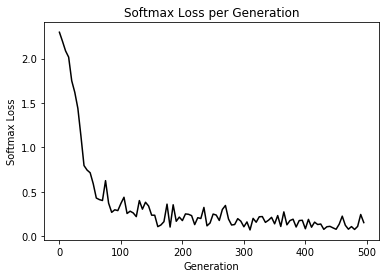

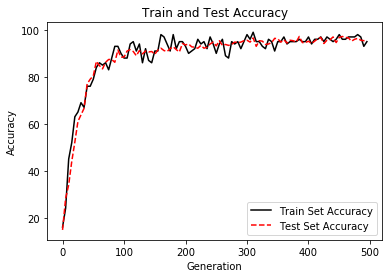

In [14]:
# Matlotlib code to plot the loss and accuracies
eval_indices = range(0, generations, eval_every)
# Plot loss over time
plt.plot(eval_indices, train_loss, 'k-')
plt.title('Softmax Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Softmax Loss')
plt.show()

# Plot train and test accuracy
plt.plot(eval_indices, train_acc, 'k-', label='Train Set Accuracy')
plt.plot(eval_indices, test_acc, 'r--', label='Test Set Accuracy')
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

Let's see how our model runs on a test of 6 random examples.

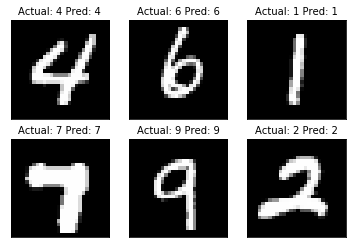

In [18]:
# Plot some samples
# Plot the 6 of the last batch results:
actuals = rand_y[0:6]
predictions = np.argmax(temp_train_preds,axis=1)[0:6]
images = np.squeeze(rand_x[0:6])

Nrows = 2
Ncols = 3
for i in range(6):
    plt.subplot(Nrows, Ncols, i+1)
    plt.imshow(np.reshape(images[i], [28,28]), cmap='Greys_r')
    plt.title('Actual: ' + str(actuals[i]) + ' Pred: ' + str(predictions[i]),
                               fontsize=10)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
plt.show()

In [16]:
writer = tf.summary.FileWriter("tenorboard_logs/",tf.get_default_graph())
writer.close()